<a href="https://colab.research.google.com/github/AlyonaKap/ml-projects/blob/main/Data_balancing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA and Class Imbalance Handling in Insurance Data

So we are going to work with an Imbalanced Insurance Data from Kaggle: https://www.kaggle.com/datasets/arashnic/imbalanced-data-practice/data. Our task is to do a small Exploratory Data Analysis (EDA), detect and handle the imbalanced class problem and build some prediction models.

In [20]:
#Libraries for working with data and making plots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

#Transform features by scaling each feature to a given range
from sklearn.preprocessing import StandardScaler

#Oversampling methods for class balancing
from imblearn.over_sampling import SMOTE, ADASYN

#Prediction models and evaluation tools
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline

# **EDA**

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab/aug_train.csv')

In [4]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,167647,Male,22,1,7.0,1,< 1 Year,No,2630.0,152.0,16,0
1,17163,Male,42,1,28.0,0,1-2 Year,Yes,43327.0,26.0,135,0
2,32023,Female,66,1,33.0,0,1-2 Year,Yes,35841.0,124.0,253,0
3,87447,Female,22,1,33.0,0,< 1 Year,No,27645.0,152.0,69,0
4,501933,Male,28,1,46.0,1,< 1 Year,No,29023.0,152.0,211,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382154 entries, 0 to 382153
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    382154 non-null  int64  
 1   Gender                382154 non-null  object 
 2   Age                   382154 non-null  int64  
 3   Driving_License       382154 non-null  int64  
 4   Region_Code           382154 non-null  float64
 5   Previously_Insured    382154 non-null  int64  
 6   Vehicle_Age           382154 non-null  object 
 7   Vehicle_Damage        382154 non-null  object 
 8   Annual_Premium        382154 non-null  float64
 9   Policy_Sales_Channel  382154 non-null  float64
 10  Vintage               382154 non-null  int64  
 11  Response              382154 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 35.0+ MB


General information:

The dataset contains information about clients of an insurance company, including their demographics (gender, age, region code), vehicle details (damage) and policy information (insurance contribution and how long the client has been with the company). All these characteristics are represented as variables.  

The column **Response** is the target feature (dependent variable). It shows whether the client is interested in purchasing vehicle insurance.

In [ ]:
df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000
mean,234392.953477,38.545691,0.998108,26.406867,0.489182,30711.271362,111.939812,154.189429,0.163811
std,139527.487326,15.226897,0.043455,13.181241,0.499884,17061.595532,54.286511,83.735107,0.370104
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,115006.250000,25.000000,1.000000,15.000000,0.000000,24546.000000,26.000000,81.000000,0.000000
50%,230461.500000,36.000000,1.000000,28.000000,0.000000,31692.000000,145.000000,154.000000,0.000000
75%,345434.750000,49.000000,1.000000,35.000000,1.000000,39447.750000,152.000000,227.000000,0.000000
max,508145.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


**Handling missing and duplicates data**

In [ ]:
df.isnull().sum()

,0
id,0
Gender,0
Age,0
Driving_License,0
Region_Code,0
Previously_Insured,0
Vehicle_Age,0
Vehicle_Damage,0
Annual_Premium,0
Policy_Sales_Channel,0


In [ ]:
df.duplicated().sum()

np.int64(0)

The dataset has 0 na and duplicate values

**Exploring data characteristics**

Let's check the distribution of numerical characteristics

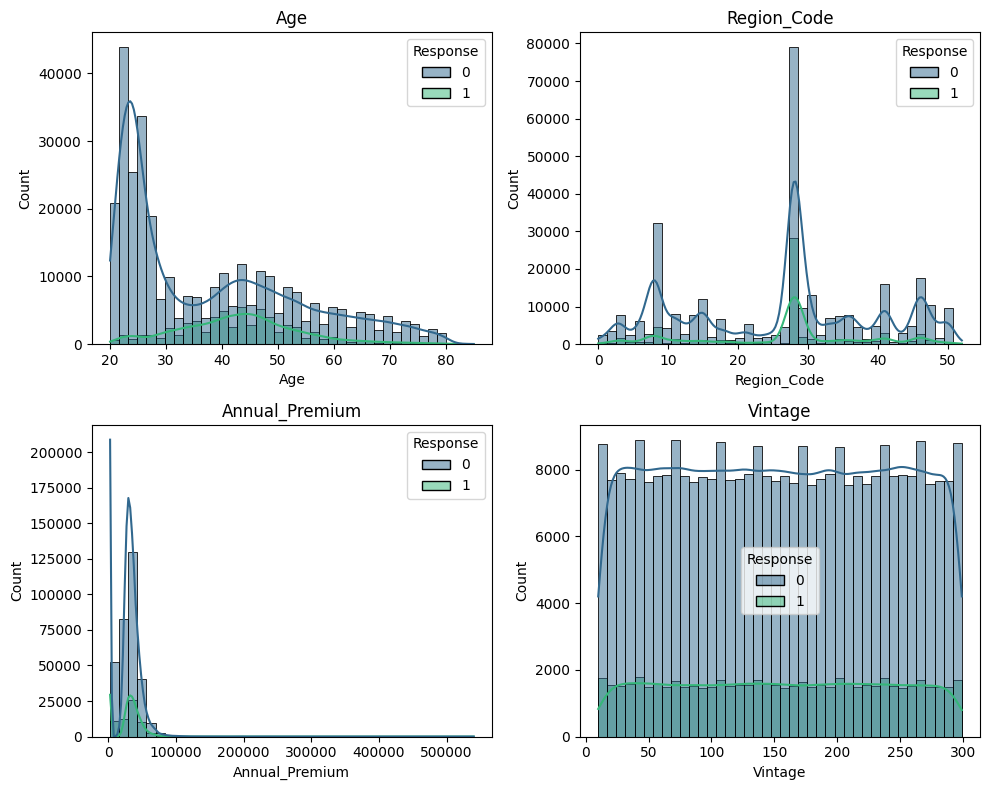

In [ ]:
num_cols = ['Age', 'Region_Code', 'Annual_Premium', 'Vintage']

fig, axes = plt.subplots(2, 2, figsize = (10,8))
axes = axes.flatten()

for col, ax in zip(num_cols, axes):
  sns.histplot(x = col, data = df, ax = ax, kde = True, hue = 'Response',
               bins = 40, palette = 'viridis')
  ax.set_title(col)

plt.tight_layout()

Conclusion:

Age: most clients are young (20–30 years), but they are less interested in

insurance compared to middle-aged people (40–50 years)

Region: one region strongly dominates, around code 30

Annual_premium: clients most often prefer to make a smaller insurance contribution

Vintage: almost uniform distribution of how long clients stay in the company’s database

The distribution of binary characteristics

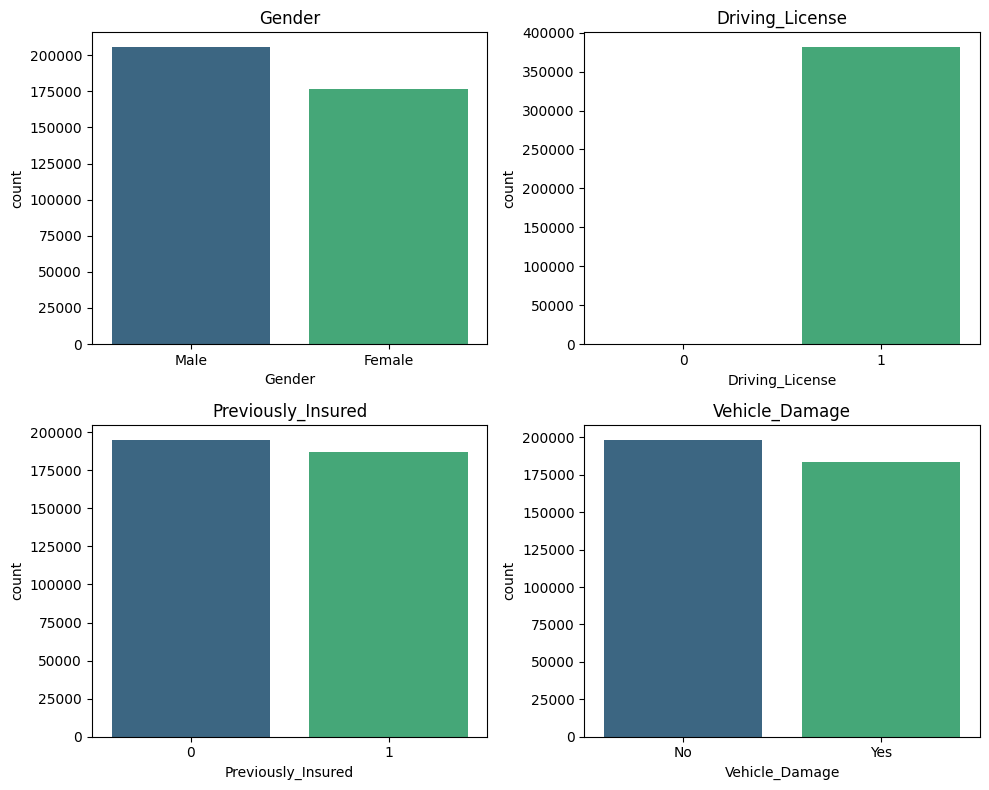

In [ ]:
cat_col = ['Gender', 'Driving_License','Previously_Insured', 'Vehicle_Damage']

fig, axes = plt.subplots(2, 2, figsize = (10,8))
axes = axes.flatten()

for col, ax in zip(cat_col, axes):
  sns.countplot(x = col, data = df, ax = ax, hue = col, legend = False,
                palette = 'viridis')
  ax.set_title(col)

plt.tight_layout()

Overall, the features are balanced. The exception is Driving_License because almost all clients have a driver's license

The distribution of target

<Axes: xlabel='Response', ylabel='count'>

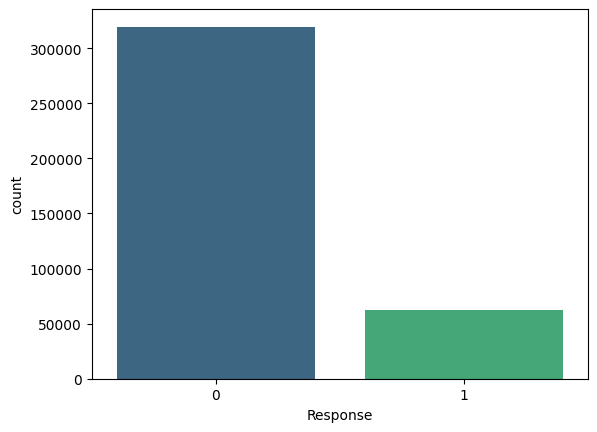

In [ ]:
sns.countplot(x = 'Response', data = df, hue = 'Response', legend = False, palette = 'viridis')

We can observe a significant dominance of class 0, which may negatively affect the prediction model's performance

**Performing data transformation**

Now we need to encode categorical variables so that the machine can understand them. Let's use Pandas' *get_dummies* to convert these categorical variables into multiple binary columns.  

In [5]:
X = df.drop(['Response'], axis = 1)
y = df['Response']

In [6]:
X = pd.get_dummies(X, dtype = int, drop_first = True)
X.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
0,167647,22,1,7.0,1,2630.0,152.0,16,1,1,0,0
1,17163,42,1,28.0,0,43327.0,26.0,135,1,0,0,1
2,32023,66,1,33.0,0,35841.0,124.0,253,0,0,0,1
3,87447,22,1,33.0,0,27645.0,152.0,69,0,1,0,0
4,501933,28,1,46.0,1,29023.0,152.0,211,1,1,0,0


At first let's split our data to train and test to prevent data leakage.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# **Creating and training the model**

We are going to use Logistic Regression, KNN and Random Forest classifiers to evaluate the prediction quality without oversampling. Since all of them solve classification problems, we need to check how sensitive each model is to class imbalance. Let's write a function that will help us apply all these models efficiently and get


Since the first two models are sensitive to feature scaling, we will implement standardization using StandardScaler. To ensure a robust evaluation, we will build a pipeline and perform cross-validation using accuracy, precision, and recall as our primary metrics.

In [22]:
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('log_regr', LogisticRegression(random_state=42))
])

pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

pipe_forest = Pipeline([
    ('forest', RandomForestClassifier(random_state=42))
])

models = {
    'LogisticRegression': pipe_lr,
    'KNN': pipe_knn,
    'RandomForest': pipe_forest
}

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall'
}

for name, m in models.items():
  scores = cross_validate(m, X_train, y_train, scoring = scoring, cv=3)
  print(f'----{name} without balancing method----')
  print('Accuracy:', scores['test_accuracy'])
  print('Precision:', scores['test_precision'])
  print('Recall:', scores['test_recall'])

----LogisticRegression without balancing method----
Accuracy: [0.87772414 0.87727891 0.87503954]
Precision: [0.68814212 0.68662803 0.67716196]
Recall: [0.46086583 0.45857225 0.45014694]
----KNN without balancing method----
Accuracy: [0.87634157 0.87778272 0.87458259]
Precision: [0.66768654 0.67302211 0.66259389]
Recall: [0.48487672 0.49082569 0.47423124]
----RandomForest without balancing method----
Accuracy: [0.89440877 0.89542813 0.89412633]
Precision: [0.85326087 0.85871272 0.85965169]
Recall: [0.42760894 0.43126433 0.42104509]


As an intermediate result, we observe that the high accuracy obtained by all models provides misleading information about their true performance. Since the dataset is imbalanced, accuracy is not an appropriate metric and the evaluation should focus on precision and recall. Precision measures the proportion of correctly predicted positive samples among all predicted positives, while recall reflects the ability of the model to identify actual positive samples.
The results show that precision is consistently higher than recall, indicating that the models predict the minority class conservatively. This demonstrates poor predictive quality for the minority class and a strong bias toward the majority class.

# **Handling an imbalanced class**

We need to adjust the balance between minority and majority classes. While undersampling can remove essencial data examples, oversampling may be a better approach to address this issue

**Smote:**

SMOTE works by utilizing a k-nearest neighbor algorithm to create synthetic data. In plain words, SMOTE looks at the samples of the minority class, picks one of its nearest neighbors, and then creates a new synthetic sample somewhere between them in the feature space. Let's add SMOTE method to our pipeline.

In [24]:
pipe_lr_smt = Pipeline([
    ('scaler', StandardScaler()),
    ('SMOTE', SMOTE(random_state = 42)),
    ('log_regr', LogisticRegression(random_state=42))
])

pipe_knn_smt = Pipeline([
    ('scaler', StandardScaler()),
    ('SMOTE', SMOTE(random_state = 42)),
    ('knn', KNeighborsClassifier())
])

pipe_forest_smt = Pipeline([
    ('SMOTE', SMOTE(random_state = 42)),
    ('forest', RandomForestClassifier(random_state=42))
])

models_smt = {
    'LogisticRegression': pipe_lr_smt,
    'KNN': pipe_knn_smt,
    'RandomForest': pipe_forest_smt
}

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall'
}

for name, m in models.items():
  scores = cross_validate(m, X_train, y_train, scoring = scoring, cv=3)
  print(f'----{name} with SMOTE----')
  print('Accuracy:', scores['test_accuracy'])
  print('Precision:', scores['test_precision'])
  print('Recall:', scores['test_recall'])

----LogisticRegression with SMOTE----
Accuracy: [0.7446806  0.74349721 0.7441855 ]
Precision: [0.38287763 0.38266241 0.38218236]
Recall: [0.91836296 0.92796732 0.91635008]
----KNN with SMOTE----
Accuracy: [0.80318227 0.80176454 0.80200827]
Precision: [0.44060935 0.43858414 0.43802835]
Recall: [0.75666571 0.75931766 0.74654147]
----RandomForest with SMOTE----
Accuracy: [0.86552702 0.86585509 0.86602927]
Precision: [0.59156493 0.59133037 0.59402316]
Recall: [0.57303612 0.58077695 0.5699233 ]


After applying SMOTE all models show a substantial increase in recall which indicates a significantly improved ability to detect the minority class. This improvement comes at the cost of lower precision and reduced accuracy which is an expected trade-off when handling imbalanced data. Overall, balancing shifts the models’ focus from maximizing accuracy to improving minority-class recognition, resulting in more informative and reliable performance metrics.

# **Comparing data before and after balancing**

Now, we’ll run a final check on the test set. We will evaluate the models using accuracy, a classification report (for class-specific precision, recall, and F1-scores), and a confusion matrix to identify specific classification errors.

In [27]:
models_test = {
    'LogisticRegression (without balancing)': pipe_lr,
    'KNN (without balancing)': pipe_knn,
    'RandomForest (without balancing)': pipe_forest,
    'LogisticRegression (SMOTE)': pipe_lr_smt,
    'KNN (SMOTE)': pipe_knn_smt,
    'RandomForest (SMOTE)': pipe_forest_smt
}

for name,m in models_test.items():
  m.fit(X_train, y_train)
  y_pred = m.predict(X_test)
  print(f'\n{name}')
  print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
  print(f"Classification report:\n{classification_report(y_test, y_pred)}")
  print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred)}")


LogisticRegression (without balancing)
Accuracy: 0.8764104637977654
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93    105365
           1       0.69      0.46      0.55     20746

    accuracy                           0.88    126111
   macro avg       0.79      0.71      0.74    126111
weighted avg       0.86      0.88      0.87    126111

Confusion matrix:
[[101019   4346]
 [ 11240   9506]]

KNN (without balancing)
Accuracy: 0.8757998905725908
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93    105365
           1       0.67      0.49      0.56     20746

    accuracy                           0.88    126111
   macro avg       0.79      0.72      0.75    126111
weighted avg       0.87      0.88      0.87    126111

Confusion matrix:
[[100370   4995]
 [ 10668  10078]]

RandomForest (without balancing)
Accuracy: 0.8935778798042994
Classifi

Without balancing, minority-class recall is low, meaning many positive cases are missed. Applying SMOTE greatly improves recall, especially for Logistic Regression, but reduces precision and accuracy. Random Forest with SMOTE provides the most balanced trade-off between precision and recall, making it the most reliable model for detecting the minority class. However, it is worth noting that the quality of the obtained models is still poor, so hyperparameter selection will be required for improvement.